# News Article Sorting

News article classification is the task of assigning predefined categories to news articles based on their content. It leverages Natural Language Processing (NLP) and machine learning techniques to automatically categorize news articles into topics like sports, politics, technology, and others. This automation streamlines information organization, retrieval, and analysis, saving time and resources compared to manual classification.

Importing dependencies

In [1]:
import re
import pandas as pd

Reading Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/nikhil-xyz/datasets/refs/heads/main/bbc_text_cls.csv')

In [3]:
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [4]:
df.shape

(2225, 2)

In [5]:
df.labels.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [6]:
df.labels.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

<Axes: >

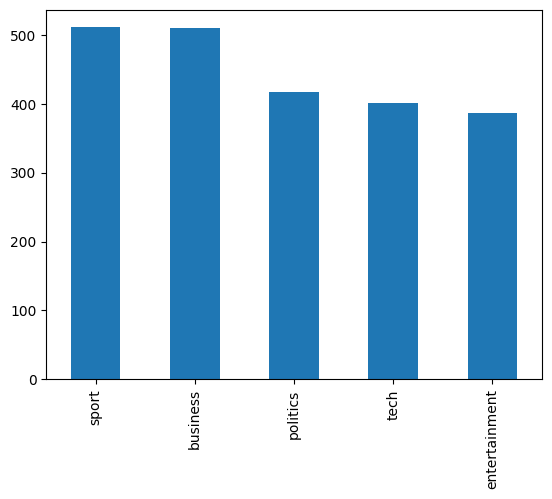

In [7]:
df.labels.value_counts().plot(kind='bar')

## Data Preprocessing
- **Regular Expressions :** Regular expressions (regex or regexp) are sequences of characters that define search patterns within text.
- **Stopwords :** Stopwords are commonly used words (like "the", "a", "is") that are often removed from text data during preprocessing for NLP tasks. Stopwords carry little semantic meaning and can overshadow more important words. Removing them helps reduce noise and improve model performance.
- **Lemmatization :** Lemmatization reduces words to their base or dictionary form (lemma). It considers the context and part of speech of words, unlike stemming. This helps group different inflected forms of a word, like "running" and "ran," under a common lemma "run." NLTK's WordNetLemmatizer is often used for this purpose.

In [8]:
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
import string
from nltk.tokenize import word_tokenize

In [11]:
import spacy
from spacy.cli import download
download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [12]:
def data_cleaning(text):
  text = text.lower()
  text = re.sub(r'(\d+)m', r'\1 million ', text)  # 7.5m -> 7.5 million
  text = re.sub(r'(\d+)bn', r'\1 billion ', text)
  text = re.sub(r"(\d+),(\d+)", r"\1\2", text)  # 146,000 -> 146000
  text = re.sub(r'(\d+).(\d+)', ' number ', text) # 145 -> number
  text = re.sub(r'(\d+)', ' number ', text)

  # text = text.replace('gmt', ' greenwich mean time ')
  text = text.replace('\n', '').replace("\'s", "").replace("\'",' ')
  text = text.replace('$', ' dollar ').replace('£', ' euro ').replace('%', ' percent ')
  text = text.replace('"', '').replace('.','')

  # tokenization
  # we are using tokenizer from spacy, since nltk's is not working in vscode for reason I don't know
  
  doc = nlp(text)
  tokens = [token.text for token in doc]

  # removing stopwords
  tokens = [token for token in tokens if token not in stop_words]

  # removing punctuations
  tokens = [token for token in tokens if token not in string.punctuation]

  # Lemmatization
  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  sentence = ' '.join(lemmas)
  return sentence

In [13]:
df.text = df.text.apply(data_cleaning)

Replacing target labels with numbers

In [14]:
target_encoding = {'business' : 0, 'entertainment' : 1, 'politics' : 2, 'sport' : 3, 'tech' : 4}
df.labels = df.labels.map(target_encoding)

Spliting data into train and test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.labels, test_size=0.2, random_state=50)

In [16]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1780,) (445,)
(1780,) (445,)


Tokens inside the longest article

In [17]:
max(df.text.apply(lambda x: len(x.split())))

2208

## Tokenization and Padding
- **Tokenization :** Tokenization is the process of breaking down text into smaller units called tokens. These tokens can be words, subwords, or characters, depending on the tokenizer used. Machine learning models work with numerical data. Tokenization converts text into a numerical representation that the model can understand.
- **Pad Sequences :**  pad_sequences is used to ensure that all sequences have the same length. This is necessary because neural networks often require input data to be in a fixed-size format.

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

In [19]:
max_words = 50000  # Total number of tokens used to train the model
max_len = 2205 # Number of words in largest article

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [20]:
sequences_matrix

array([[    0,     0,     0, ...,    26,   564,   547],
       [    0,     0,     0, ...,   668,  3536, 15332],
       [    0,     0,     0, ...,   360,  1869,   634],
       ...,
       [    0,     0,     0, ...,  2897,  3369,   925],
       [    0,     0,     0, ..., 29153,   601, 15312],
       [    0,     0,     0, ...,  9298,   804,  8865]])

## RNN Network
- **Embedding Layer :** Transforms word indices into dense vectors (word embeddings). Captures semantic relationships between words.
- **Bidirectional LSTM Layer :** Processes the sequence in both forward and backward directions. Learns long-term dependencies in the text.
- **Dense Layers (Feature Extractors) :** Multiple dense layers with ReLU activation extract features from the LSTM output. Increase the model's capacity to learn complex patterns.
- **Output Layer :** A dense layer with sigmoid activation outputs probabilities for each category. Used for multi-class classification.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(max_words, 128))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
# model.add(Dense(32, activation='relu'))
# Final layer
model.add(Dense(5, activation='sigmoid'))

In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [25]:
# starting model training
history = model.fit(sequences_matrix, y_train, batch_size=128, epochs=8, validation_split=0.2)

Epoch 1/8
12/12 [==============================] - 254s 21s/step - loss: 1.6000 - accuracy: 0.2360 - val_loss: 1.5914 - val_accuracy: 0.2135
Epoch 2/8
12/12 [==============================] - 233s 19s/step - loss: 1.5474 - accuracy: 0.2669 - val_loss: 1.5382 - val_accuracy: 0.3146
Epoch 3/8
12/12 [==============================] - 240s 20s/step - loss: 1.3326 - accuracy: 0.4340 - val_loss: 1.2166 - val_accuracy: 0.4326
Epoch 4/8
12/12 [==============================] - 320s 27s/step - loss: 1.0817 - accuracy: 0.5695 - val_loss: 1.1304 - val_accuracy: 0.5702
Epoch 5/8
12/12 [==============================] - 310s 25s/step - loss: 0.8854 - accuracy: 0.6636 - val_loss: 0.9046 - val_accuracy: 0.6208
Epoch 6/8
12/12 [==============================] - 266s 22s/step - loss: 0.7282 - accuracy: 0.7662 - val_loss: 0.8619 - val_accuracy: 0.6180
Epoch 7/8
12/12 [==============================] - 361s 31s/step - loss: 0.6685 - accuracy: 0.8841 - val_loss: 0.7469 - val_accuracy: 0.7584
Epoch 8/8
12/

In [26]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [27]:
lstm_prediction = model.predict(test_sequences_matrix)

14/14 [==============================] - 27s 569ms/step


In [28]:
import numpy as np

In [29]:
pred = []
for prediction in lstm_prediction:
  pred.append(np.argmax(prediction))

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
cm

array([[98,  0, 10,  0,  0],
       [34, 36,  8,  2,  0],
       [ 0,  0, 66,  0,  0],
       [ 0,  0,  2, 95,  0],
       [45,  2,  4,  3, 40]], dtype=int64)

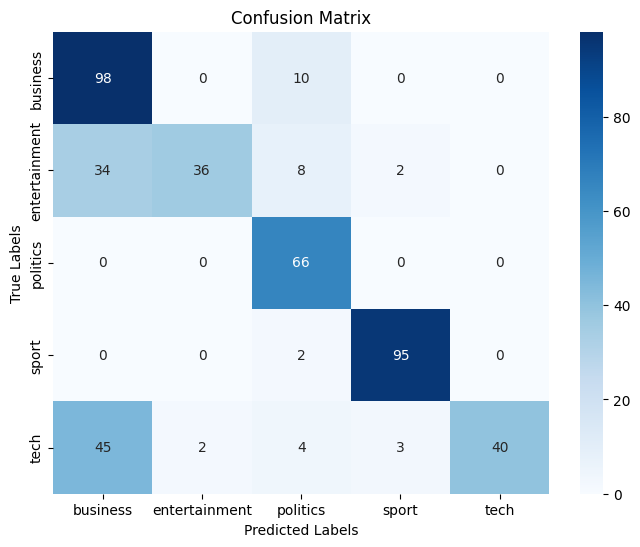

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_encoding.keys(),
            yticklabels=target_encoding.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

plt.savefig('confusion_matrix.png')
plt.show()

## Performance Matrix
- **Accuracy:** Overall correctness of the model (total correct predictions / total predictions).
- **Precision:** Out of the positive predictions, how many were actually positive (true positives / (true positives + false positives)). Focuses on minimizing false positives.
- **Recall:** Out of the actual positives, how many were correctly predicted (true positives / (true positives + false negatives)). Focuses on minimizing false negatives.
- **F1-score:** Harmonic mean of precision and recall. Provides a balance between the two metrics.

Accuracy: 0.7528089887640449
Precision: 0.831766480570117
Recall: 0.7528089887640449
F1-score: 0.7384406738341001


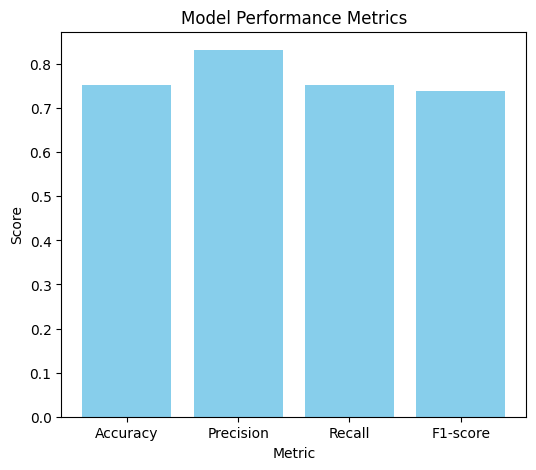

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Create a dictionary to store the metrics and their values
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}

# Create bar plot
plt.figure(figsize=(6, 5))  # Adjust figure size if needed
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.savefig('model_performance_bar_plot.png')
plt.show()

business: 0.9074074074074074
entertainment: 0.45
politics: 1.0
sport: 0.979381443298969
tech: 0.425531914893617


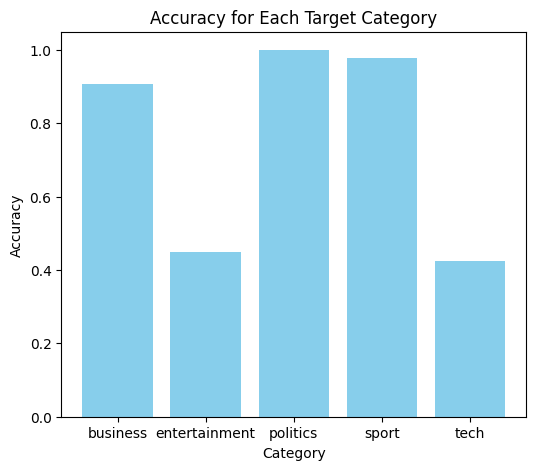

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming 'y_test' and 'pred' are defined as in your provided code
# and 'target_encoding' maps category names to numerical labels

# Get unique labels
unique_labels = np.unique(y_test)

# Calculate accuracy for each category and store in a dictionary
category_accuracies = {}
for label in unique_labels:
    indices = np.where(y_test == label)[0]
    accuracy = accuracy_score(np.array(y_test)[indices], np.array(pred)[indices])

    # Get category name from target_encoding
    for category_name, category_label in target_encoding.items():
        if category_label == label:
            category_accuracies[category_name] = accuracy
            break
for category, accuracy in category_accuracies.items():
    print(f"{category}: {accuracy}")
# Create bar plot
plt.figure(figsize=(6, 5))
plt.bar(category_accuracies.keys(), category_accuracies.values(), color='skyblue')
plt.title('Accuracy for Each Target Category')
plt.xlabel('Category')
plt.ylabel('Accuracy')

plt.savefig('accuracy_bar_plot.png')
plt.show()

### **Creating MongoDB account and pushing the dataset over there**

MongoDB is a popular NoSQL database. It stores data in flexible, JSON-like documents. This makes it great for handling data that doesn't fit neatly into traditional rows and columns.

It's known for being scalable and easy to use, especially for developers working with data that changes frequently.

In [34]:
pip install pymongo

Creating connection with mongodb client

In [35]:
import os
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

uri = os.getenv('MONGODB_URI')

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [36]:
data = pd.read_csv('https://raw.githubusercontent.com/nikhil-xyz/datasets/refs/heads/main/bbc_text_cls.csv')

In [37]:
data.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


converting dataframe to dictionary format.

In [38]:
data = data.to_dict(orient="records")

In [39]:
data[0]

{'text': 'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will t

uploading data to mongodb

In [40]:
DB_NAME = "News_Articles"
COLLECTION_NAME = "news_data"
data_base = client[DB_NAME]
collection = data_base[COLLECTION_NAME]

collection_names = data_base.list_collection_names()
# print(collection_names)
if COLLECTION_NAME not in collection_names:
    rec = collection.insert_many(data)
else:
    print("Data already exist")

Data already exist
